In [ ]:
pip install scikit-plot

## Lioad Libraries and Drive

In [ ]:
import glob, os.path
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.layers import Lambda, Layer, ReLU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
from keras.models import load_model
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import pandas as pd
import seaborn as sn
from sklearn.metrics import roc_curve,roc_auc_score
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/Drive')  # import data from drive

In [ ]:
import sys
sys.path.append('/content/drive')

## Load Data

In [ ]:
data_entrenamiento = '/content/Drive/My Drive/HAM10000/Base de Datos_Clasificada y Aumentada(7_Clases)/Train_final'
data_validacion = '/content/Drive/My Drive/HAM10000/Base de Datos_Clasificada y Aumentada(7_Clases)/Validation'
data_text = '/content/Drive/My Drive/HAM10000/Base de Datos_Clasificada y Aumentada(7_Clases)/Text'

## Graphics Card provived by Google Colap

In [ ]:
!nvidia-smi

Fri Feb 12 16:09:58 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Load Model InceptionV3

In [ ]:

pre_trained_model = tf.keras.applications.InceptionV3(
                    include_top=False,
                    weights= 'imagenet',
                    input_shape = (224, 224, 3)
                    )

87916544/87910968 [==============================] - 1s 0us/step


In [ ]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 111, 111, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 111, 111, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [ ]:

for i, layer in enumerate(pre_trained_model.layers):
   print(i, layer.name)

0 input_1
1 conv2d
2 batch_normalization
3 activation
4 conv2d_1
5 batch_normalization_1
6 activation_1
7 conv2d_2
8 batch_normalization_2
9 activation_2
10 max_pooling2d
11 conv2d_3
12 batch_normalization_3
13 activation_3
14 conv2d_4
15 batch_normalization_4
16 activation_4
17 max_pooling2d_1
18 conv2d_8
19 batch_normalization_8
20 activation_8
21 conv2d_6
22 conv2d_9
23 batch_normalization_6
24 batch_normalization_9
25 activation_6
26 activation_9
27 average_pooling2d
28 conv2d_5
29 conv2d_7
30 conv2d_10
31 conv2d_11
32 batch_normalization_5
33 batch_normalization_7
34 batch_normalization_10
35 batch_normalization_11
36 activation_5
37 activation_7
38 activation_10
39 activation_11
40 mixed0
41 conv2d_15
42 batch_normalization_15
43 activation_15
44 conv2d_13
45 conv2d_16
46 batch_normalization_13
47 batch_normalization_16
48 activation_13
49 activation_16
50 average_pooling2d_1
51 conv2d_12
52 conv2d_14
53 conv2d_17
54 conv2d_18
55 batch_normalization_12
56 batch_normalization_14
5

In [ ]:
for layer in pre_trained_model.layers[:150]: #400
   layer.trainable = False
for layer in pre_trained_model.layers[150:]:
   layer.trainable = True

In [ ]:

train_datagen = ImageDataGenerator( rescale = 1.0/255 )  # images normalization 
validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )


train_generator = train_datagen.flow_from_directory(data_entrenamiento,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    color_mode="rgb",
                                                    target_size=(224, 224),
                                                    )     

validation_generator =  validation_datagen.flow_from_directory(data_validacion,
                                                         batch_size=64,
                                                         class_mode  = 'categorical',
                                                         color_mode="rgb",
                                                         target_size = (224, 224))


test_generator =  test_datagen.flow_from_directory(data_text,
                                                         batch_size=64,
                                                         color_mode="rgb",
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))



Found 32201 images belonging to 7 classes.
Found 7150 images belonging to 7 classes.
Found 3574 images belonging to 7 classes.


## Hidden Layer Design

In [ ]:
def model_new():
  inputs = tf.keras.Input(shape=(224, 224, 3))

  x = pre_trained_model(inputs)

  layers = tf.keras.layers.GlobalAveragePooling2D()(x)
  #layers = Flatten(name="flatten")(x)

  #Hidden Layers
  layers = Dense(512)(layers)
  layers = BatchNormalization()(layers)
  layers = ReLU()(layers)

  layers = Dense(128)(layers)
  layers = BatchNormalization()(layers)
  layers = ReLU()(layers)


  layers = Dense(64)(layers)
  layers = BatchNormalization()(layers)
  layers = ReLU()(layers)


  layers = Dense(32)(layers)
  layers = BatchNormalization()(layers)
  layers = ReLU()(layers)

  #Clasification Layer
  predictions = Dense(7, activation="softmax", name="output_1")(layers)
  model = Model(inputs = inputs, outputs=predictions)

  return model

In [ ]:
modelFT = model_new()
modelFT.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 51200)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6553728   
_________________________________________________________________
re_lu (ReLU)                 (None, 128)               0         
_________________________________________________________________
output_1 (Dense)             (None, 7)                 903       
Total params: 28,357,415
Trainable params: 23,921,607
Non-trainable params: 4,435,808
_________________________________________

Optimazer

In [ ]:


modelFT.compile(
    optimizer="Adamax",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
    )

In [ ]:

DESIRED_ACCURACY = 0.999
INIT_LR = 1e-3
def exp_decay(epoch):
  initial_lrate = 1e-3
  k = 0.095
  lrate = initial_lrate * np.exp(-k*epoch)
  return lrate



class LossHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.losses = []
    self.lr = []

  def on_epoch_end(self, batch, logs={}):
    self.losses.append(logs.get('loss'))
    self.lr.append(exp_decay(len(self.losses)))

class end_train(tf.keras.callbacks.Callback):
        def on_epoch_end(self,epoch,log={}):
            if log.get('val_accuracy')>DESIRED_ACCURACY:
                print("\nReached"+str(DESIRED_ACCURACY)+"% val_accuracy so cancelling training!")
                self.model.stop_training = True
end_t = end_train()
loss_history = LossHistory()
lrate = LearningRateScheduler(exp_decay)       
callbacks_list = [loss_history,lrate,end_t]

callbacks=callbacks_list

## Train Model

In [ ]:
steps_per_epoch = train_generator.n // 64
validation_steps = validation_generator.n // 64
history = modelFT.fit (train_generator,             
                         validation_data = validation_generator,             
                         steps_per_epoch = steps_per_epoch,           
                         epochs = 33,             
                         validation_steps = validation_steps,             
                         verbose = 2,
                         #callbacks=callbacks
                        )

Epoch 1/33
503/503 - 7414s - loss: 0.9627 - accuracy: 0.6530 - val_loss: 0.4005 - val_accuracy: 0.8491
Epoch 2/33
503/503 - 249s - loss: 0.2867 - accuracy: 0.8966 - val_loss: 0.3199 - val_accuracy: 0.8819
Epoch 3/33
503/503 - 242s - loss: 0.1428 - accuracy: 0.9503 - val_loss: 0.2437 - val_accuracy: 0.9186
Epoch 4/33
503/503 - 241s - loss: 0.0928 - accuracy: 0.9672 - val_loss: 0.2865 - val_accuracy: 0.9195
Epoch 5/33
503/503 - 243s - loss: 0.0610 - accuracy: 0.9792 - val_loss: 0.2361 - val_accuracy: 0.9309
Epoch 6/33
503/503 - 240s - loss: 0.0445 - accuracy: 0.9847 - val_loss: 0.2496 - val_accuracy: 0.9274
Epoch 7/33
503/503 - 240s - loss: 0.0433 - accuracy: 0.9857 - val_loss: 0.2027 - val_accuracy: 0.9392
Epoch 8/33
503/503 - 240s - loss: 0.0311 - accuracy: 0.9898 - val_loss: 0.2419 - val_accuracy: 0.9358
Epoch 9/33
503/503 - 241s - loss: 0.0187 - accuracy: 0.9944 - val_loss: 0.1859 - val_accuracy: 0.9466
Epoch 10/33
503/503 - 241s - loss: 0.0123 - accuracy: 0.9961 - val_loss: 0.2240 -

## Save Model

In [ ]:


modelFT.save('/content/Drive/MyDrive/modelos Ham10000/modelo_inceptionV3.h5')  # creates a HDF5 file 'my_model.h5'


#model = load_model('/content/Drive/My Drive/HAM10000/model_final_prueba.h5')

In [ ]:
modelFT.save('/content/Drive/MyDrive/modelos Ham10000/experimento 3- base de datos aumentada/model_v3.h5')

#Results

NameError: ignored

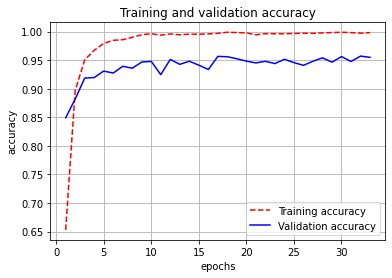

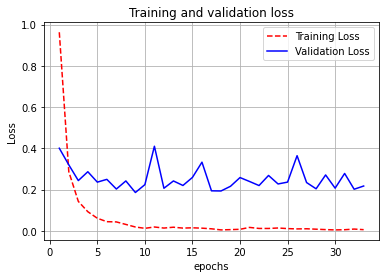

<Figure size 432x288 with 0 Axes>

In [ ]:
acc = history.history[ 'accuracy' ] # con drop
val_acc = history.history[ 'val_accuracy' ]
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
#lr = history.history['lr' ]
epochs = range(1,len(acc)+1,1)
plt.plot ( epochs, acc, 'r--', label='Training accuracy' )
plt.grid(True)
plt.plot ( epochs, val_acc, 'b', label='Validation accuracy')
plt.title ('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epochs')
plt.legend()
plt.figure()
plt.plot ( epochs, loss, 'r--' , label='Training Loss' )
plt.grid(True)
plt.plot ( epochs, val_loss , 'b', label='Validation Loss'  )
plt.grid(True)
plt.title ('Training and validation loss' )
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.legend()
plt.figure()
#plt.plot ( epochs, loss, 'r--' )
plt.plot ( epochs, lr, 'b' )
plt.grid(True)
plt.title ('lr  and validation loss' )
plt.ylabel('value')
plt.xlabel('epochs')
plt.legend()
plt.figure()

In [ ]:
test_lost, test_acc= modelFT.evaluate(test_generator)
print ("Test Accuracy:", test_acc)

In [ ]:
acc 

[0.6530478596687317,
 0.896630048751831,
 0.9503375887870789,
 0.9671717882156372,
 0.9791517853736877,
 0.9846594333648682,
 0.9856551885604858,
 0.9898248314857483,
 0.9944301247596741,
 0.9961103796958923,
 0.9936521649360657,
 0.9957992434501648,
 0.994336724281311,
 0.995425820350647,
 0.9952391386032104,
 0.9958614706993103,
 0.9967949986457825,
 0.9987553358078003,
 0.998195230960846,
 0.9975728988647461,
 0.994336724281311,
 0.9962348937988281,
 0.9961726069450378,
 0.9960170388221741,
 0.9965460300445557,
 0.9970750212669373,
 0.9968261122703552,
 0.9975728988647461,
 0.9982263445854187,
 0.9987242221832275,
 0.9981330037117004,
 0.9970439076423645,
 0.9980707764625549]

In [ ]:
val_acc


[0.8490990996360779,
 0.881897509098053,
 0.9186373949050903,
 0.9194819927215576,
 0.9308840036392212,
 0.9273648858070374,
 0.9391891956329346,
 0.9358108043670654,
 0.9466497898101807,
 0.9477759003639221,
 0.9245495200157166,
 0.951295018196106,
 0.9425675868988037,
 0.9480574131011963,
 0.9411599040031433,
 0.9335585832595825,
 0.9565033912658691,
 0.955940306186676,
 0.9524211883544922,
 0.9481981992721558,
 0.9451013803482056,
 0.9479166865348816,
 0.9439752101898193,
 0.9514358043670654,
 0.9456644058227539,
 0.9408783912658691,
 0.9480574131011963,
 0.9539695978164673,
 0.9463682174682617,
 0.9562218189239502,
 0.9476351141929626,
 0.9570664167404175,
 0.9548141956329346]

In [ ]:
loss

[0.9626961350440979,
 0.2866872251033783,
 0.14281125366687775,
 0.09277132153511047,
 0.06102734059095383,
 0.04449426010251045,
 0.04330959916114807,
 0.031065063551068306,
 0.01866784505546093,
 0.012272500433027744,
 0.018707172945141792,
 0.013516642153263092,
 0.017640020698308945,
 0.013358082622289658,
 0.014784303493797779,
 0.013018837198615074,
 0.009937732480466366,
 0.004615164361894131,
 0.0059347208589315414,
 0.0075628082267940044,
 0.01667637750506401,
 0.011671798303723335,
 0.011589469388127327,
 0.013835499063134193,
 0.010904746130108833,
 0.009444054216146469,
 0.010093776509165764,
 0.008037305437028408,
 0.006075507961213589,
 0.004539672285318375,
 0.005526288412511349,
 0.008629858493804932,
 0.005753371398895979]

In [ ]:
val_loss

[0.40049025416374207,
 0.31993725895881653,
 0.24371205270290375,
 0.28653770685195923,
 0.23613207042217255,
 0.24962279200553894,
 0.20268328487873077,
 0.24194864928722382,
 0.1859000325202942,
 0.22404050827026367,
 0.41015109419822693,
 0.20646414160728455,
 0.241858571767807,
 0.21997439861297607,
 0.2590125799179077,
 0.3328337073326111,
 0.19403515756130219,
 0.19324946403503418,
 0.21602985262870789,
 0.258344441652298,
 0.23933370411396027,
 0.21960239112377167,
 0.2685185670852661,
 0.2272680252790451,
 0.23624922335147858,
 0.36429840326309204,
 0.2341202348470688,
 0.2038731724023819,
 0.2709614932537079,
 0.20691892504692078,
 0.27821457386016846,
 0.20170089602470398,
 0.21733175218105316]

In [ ]:
lr

[0.001,
 0.00090937293,
 0.00082695915,
 0.0007520143,
 0.00068386144,
 0.00062188506,
 0.00056552544,
 0.00051427353,
 0.00046766642,
 0.0004252832,
 0.000386741,
 0.00035169182,
 0.00031981902,
 0.00029083475,
 0.00026447728,
 0.00024050847,
 0.00021871188,
 0.00019889067,
 0.0001808658,
 0.00016447446,
 0.00014956862,
 0.00013601365,
 0.00012368713,
 0.00011247773,
 0.000102284204,
 9.301449e-05,
 8.458486e-05,
 7.691918e-05,
 6.994822e-05,
 6.360902e-05,
 5.784432e-05,
 5.260206e-05,
 4.783489e-05]

Load Model

In [ ]:
modelFT = load_model('/content/Drive/My Drive/HAM10000/model_final_prueba.h5')

In [ ]:
test_lost, test_acc= modelFT.evaluate(test_generator)
print ("Test Accuracy:", test_acc)

In [ ]:
test_lost, test_acc= modelFT.evaluate(test_generator)
print ("Test Accuracy:", test_acc)

56/56 [==============================] - 628s 11s/step - loss: 0.2404 - accuracy: 0.9516
Test Accuracy: 0.9515948295593262
